# COVID-19 Pandemic | Analysis and Prediction

#### Done by: *Sarah M. Alabdulhadi*

### Introduction

**Coronavirus disease 2019 (COVID-19)** is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The disease was first identified in 2019 in Wuhan, the capital of Hubei, China, and has since spread globally, resulting in the 2019–2020 coronavirus pandemic.

The virus is typically spread during close contact and via respiratory droplets produced when people cough or sneeze.

This notebook studies COVID-19 behavior worldwide and focuses on its behavior in most infectious contries and compare them to Saudi Arabia. 

In [32]:
# essential libraries
import json
import random
from urllib.request import urlopen

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import calmap
import folium

# color pallette
cnf = '#393e46' # confirmed - grey
dth = '#ff2e63' # death - red
rec = '#21bf73' # recovered - cyan
act = '#fe9801' # active case - yellow

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML

import time
%matplotlib inline

In [33]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [34]:
full_table = pd.read_csv('covid_19_clean_complete.csv', parse_dates=['Date'])

In [35]:
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[cases] = full_table[cases].fillna(0)

# latest condensed
full_latest = full_table[full_table['Date'] == max(full_table['Date'])].reset_index()
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

##### Cases worldwide

The dataset covers 163 countries and almost 2 full months from 2020. From January 21st until March 24th. 
This is enough data to start analyzing pandemic data and get some insights. 
Let's start with general statistics:

In [36]:
temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)
temp.style.background_gradient(cmap='Pastel1')

,Date,Confirmed,Deaths,Recovered,Active
0,2020-03-23 00:00:00,336004,14643,98334,223027


### Study Approach

I will start by categorizing counties based on three criteria, and then study the top 5 countries on each and compare it with Saudi Arabia. 

In [65]:
flg = full_latest_grouped
fig = px.bar(flg.sort_values('Confirmed', ascending=False).head(5).sort_values('Confirmed', ascending=True), 
             x="Confirmed", y="Country/Region", title='Confirmed Cases', text='Confirmed', orientation='h', 
             width=600, height=400, range_x = [0, max(flg['Confirmed'])+10000])
fig.update_traces(marker_color="lightblue", opacity=0.8, textposition='outside')
fig.show()

##### Criterion 1: Number of confiremd cases. 
        1. China.
        2. Italy.
        3. United States.
        4. Spain.
        5. Germany.

In [39]:
temp = full_table.copy()
# load population dataset
pop_clean_data = pd.read_csv("population_clean.csv")

# select only the latest data
pop = pop_clean_data.loc[:, ['Country Name', '2018']]

# substitute for missing values
cols = ['French Guiana', 'Martinique', 'Palestine' , 'Republic of Ireland', 'Saint Barthelemy', 'Taiwan', 'Vatican City']
pops = [290691, 376480, 4750000, 4920455, 7122, 23476640, 1000]
for c, p in zip(cols, pops):
    temp.loc[temp['Country/Region']== c, 'Population'] = p

# replace country names 
name = {
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran (Islamic Republic of)',
    'Macao SAR, China': 'Macau',
    'Hong Kong SAR': 'Hong Kong',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Korea, Rep.': 'Republic of Korea',
    'United Kingdom': 'UK',
    'United States': 'US' }
pop.loc[:, 'Country Name'] = pop.loc[: 'Country Name'].replace(name)

# merge dataframes
temp = pd.merge(full_latest_grouped, pop, how='left', right_on='Country Name', left_on='Country/Region')
# print(temp[temp['Country Name'].isna()])

temp = temp[['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active', '2018']]
temp.columns = ['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population']
    
# calculate Confirmed/Population
temp['Confirmed Per Million People'] = round(temp['Confirmed']/temp['Population']*1000000, 2)

# countries with population greater that 1 million only
temp = temp[temp['Population']>1000000].sort_values('Confirmed Per Million People', ascending=False).reset_index(drop=True)
# temp.head()

fig = px.bar(temp.head(5).sort_values('Confirmed Per Million People', ascending=True), 
             x='Confirmed Per Million People', y='Country/Region', orientation='h', 
             width=600, height=400, text='Confirmed Per Million People', title='Confirmed cases Per Million People',
             range_x = [0, max(temp['Confirmed Per Million People'])+100])
fig.update_traces(textposition='outside', marker_color='lightblue', opacity=0.7)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

##### Criterion 2: Ratio of cases to population.
        1. Italy.
        2. Switzerland.
        3. Spain.
        4. Norway.
        5. Austria.

In [40]:
temp = full_table.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==min(temp['Date'])].reset_index(drop=True)
temp = temp[temp['Confirmed']!=0]
temp.style.background_gradient(cmap='Pastel1')

,Country/Region,Date,Confirmed,Deaths,Recovered,Active
33,China,2020-01-22 00:00:00,548,17,28,503
88,Japan,2020-01-22 00:00:00,2,0,0,2
154,South Korea,2020-01-22 00:00:00,1,0,0,1
162,Taiwan*,2020-01-22 00:00:00,1,0,0,1
164,Thailand,2020-01-22 00:00:00,2,0,0,2


##### Criterion 3: Date of first reported case.
        1. China.
        2. Japan.
        3. South Korea.
        4. Taiwan.
        5. Thailand.

In [41]:
Saudi = full_table[full_table['Country/Region']=='Saudi Arabia'] 
China = full_table[full_table['Country/Region']=='China']
Italy = full_table[full_table['Country/Region']=='Italy']
US = full_table[full_table['Country/Region']=='US'] 
Spain = full_table[full_table['Country/Region']=='Spain']
Germany = full_table[full_table['Country/Region']=='Germany'] 
Taiwan = full_table[full_table['Country/Region']=='Taiwan*']
Thailand = full_table[full_table['Country/Region']=='Thailand'] 
Japan = full_table[full_table['Country/Region']=='Japan']
SouthKorea = full_table[full_table['Country/Region']=='South Korea'] 
Switzerland = full_table[full_table['Country/Region']=='Switzerland']
Norway = full_table[full_table['Country/Region']=='Norway'] 
Austria = full_table[full_table['Country/Region']=='Austria'] 

Therefore, will be studying the above 12 counties and Saudi Arabia in this notebook. 

### Exploratory Data Anaysis (EDA): 

**The following line plots show the Confirmed, Deaths and Recovered cases for the 13 countries over time.**

Text(0.5, 0, 'Date')

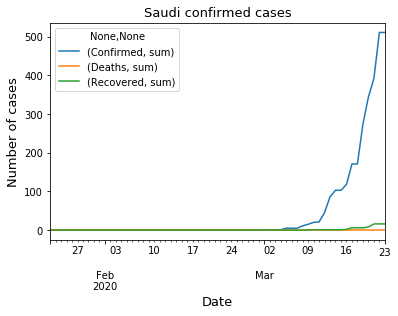

In [42]:
#saudi
confirmed_total_date_saudi = Saudi.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_saudi = Saudi.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_saudi = Saudi.groupby(['Date']).agg({'Recovered':['sum']})
total_date_saudi = confirmed_total_date_saudi.join(deaths_total_date_saudi)
total_date_saudi = total_date_saudi.join(recovered_total_date_saudi)

fig, (ax1) = plt.subplots(1, figsize=(6,4))
total_date_saudi.plot(ax=ax1)
ax1.set_title("Saudi confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

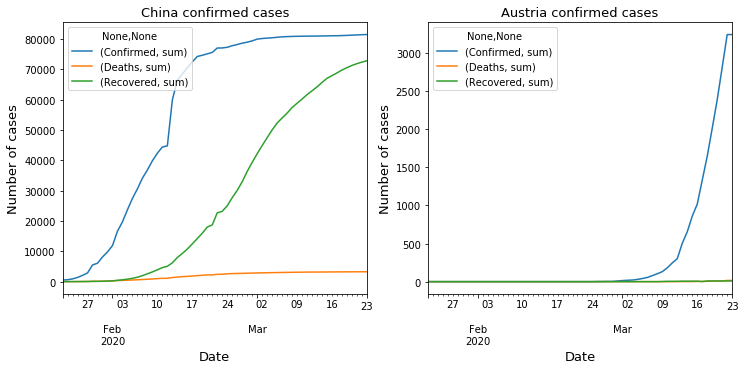

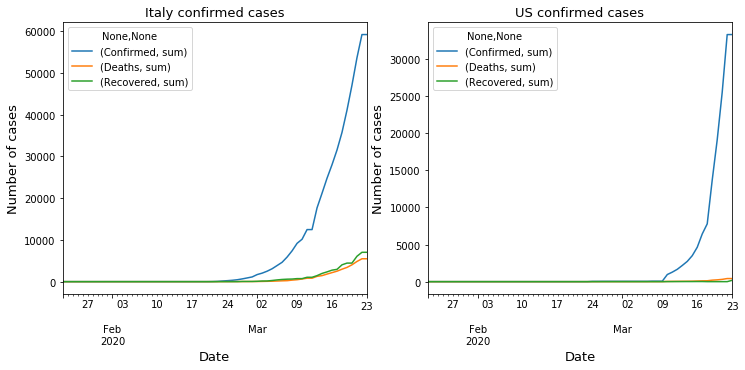

In [43]:
Japan = full_table[full_table['Country/Region']=='Japan']
SouthKorea = full_table[full_table['Country/Region']=='South Korea'] 
Switzerland = full_table[full_table['Country/Region']=='Switzerland']
Norway = full_table[full_table['Country/Region']=='Norway'] 
Austria = full_table[full_table['Country/Region']=='Austria'] 

#china
confirmed_total_date_china = China.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_china = China.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_china = China.groupby(['Date']).agg({'Recovered':['sum']})
total_date_china = confirmed_total_date_china.join(deaths_total_date_china)
total_date_china = total_date_china.join(recovered_total_date_china)

#austria
confirmed_total_date_austria = Austria.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_austria = Austria.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_austria = Austria.groupby(['Date']).agg({'Recovered':['sum']})
total_date_austria = confirmed_total_date_austria.join(deaths_total_date_austria)
total_date_austria = total_date_austria.join(recovered_total_date_austria)


#italy
confirmed_total_date_italy = Italy.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_italy = Italy.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_italy = Italy.groupby(['Date']).agg({'Recovered':['sum']})
total_date_italy = confirmed_total_date_italy.join(deaths_total_date_italy)
total_date_italy = total_date_italy.join(recovered_total_date_italy)

#US
confirmed_total_date_US = US.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_US = US.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_US = US.groupby(['Date']).agg({'Recovered':['sum']})
total_date_US = confirmed_total_date_US.join(deaths_total_date_US)
total_date_US = total_date_US.join(recovered_total_date_US)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
total_date_china.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
total_date_austria.plot(ax=ax2)
ax2.set_title("Austria confirmed cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12,5))
total_date_italy.plot(ax=ax3)
ax3.set_title("Italy confirmed cases", size=13)
ax3.set_ylabel("Number of cases", size=13)
ax3.set_xlabel("Date", size=13)
total_date_US.plot(ax=ax4)
ax4.set_title("US confirmed cases", size=13)
ax4.set_ylabel("Number of cases", size=13)
ax4.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

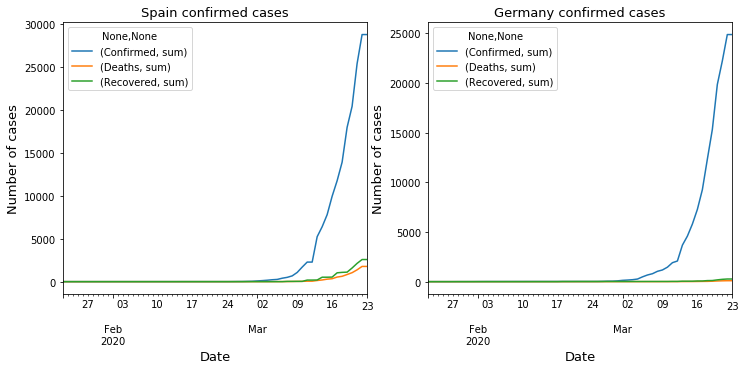

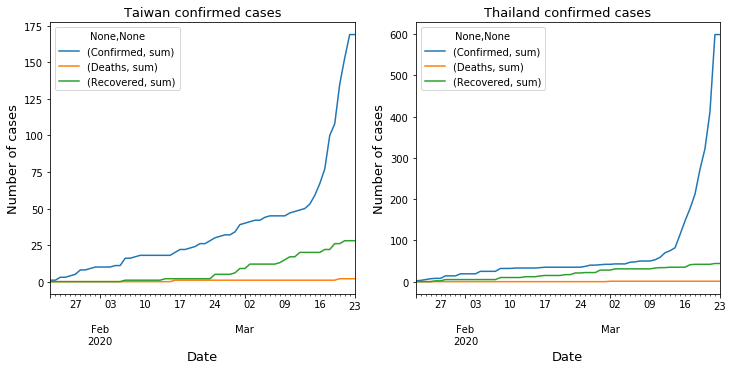

In [44]:
#spain
confirmed_total_date_spain = Spain.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_spain = Spain.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_spain = Spain.groupby(['Date']).agg({'Recovered':['sum']})
total_date_spain = confirmed_total_date_spain.join(deaths_total_date_spain)
total_date_spain = total_date_spain.join(recovered_total_date_spain)

#germany
confirmed_total_date_germany = Germany.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_germany = Germany.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_germany = Germany.groupby(['Date']).agg({'Recovered':['sum']})
total_date_germany = confirmed_total_date_germany.join(deaths_total_date_germany)
total_date_germany = total_date_germany.join(recovered_total_date_germany)

#taiwan
confirmed_total_date_taiwan = Taiwan.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_taiwan = Taiwan.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_taiwan = Taiwan.groupby(['Date']).agg({'Recovered':['sum']})
total_date_taiwan = confirmed_total_date_taiwan.join(deaths_total_date_taiwan)
total_date_taiwan = total_date_taiwan.join(recovered_total_date_taiwan)

#thailand
confirmed_total_date_thailand = Thailand.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_thailand = Thailand.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_thailand = Thailand.groupby(['Date']).agg({'Recovered':['sum']})
total_date_thailand = confirmed_total_date_thailand.join(deaths_total_date_thailand)
total_date_thailand = total_date_thailand.join(recovered_total_date_thailand)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
total_date_spain.plot(ax=ax1)
ax1.set_title("Spain confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
total_date_germany.plot(ax=ax2)
ax2.set_title("Germany confirmed cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12,5))
total_date_taiwan.plot(ax=ax3)
ax3.set_title("Taiwan confirmed cases", size=13)
ax3.set_ylabel("Number of cases", size=13)
ax3.set_xlabel("Date", size=13)
total_date_thailand.plot(ax=ax4)
ax4.set_title("Thailand confirmed cases", size=13)
ax4.set_ylabel("Number of cases", size=13)
ax4.set_xlabel("Date", size=13)

Text(0.5, 0, 'Date')

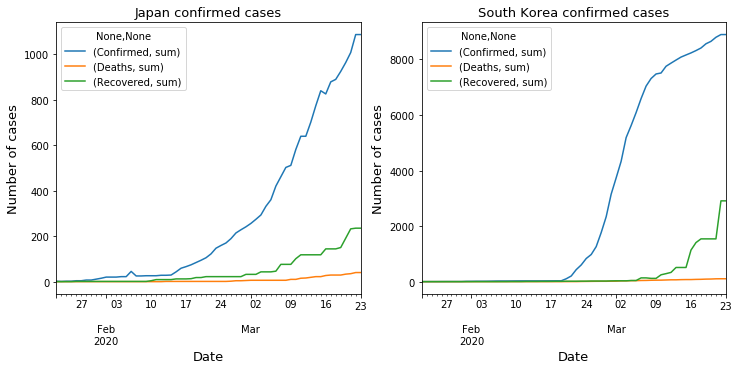

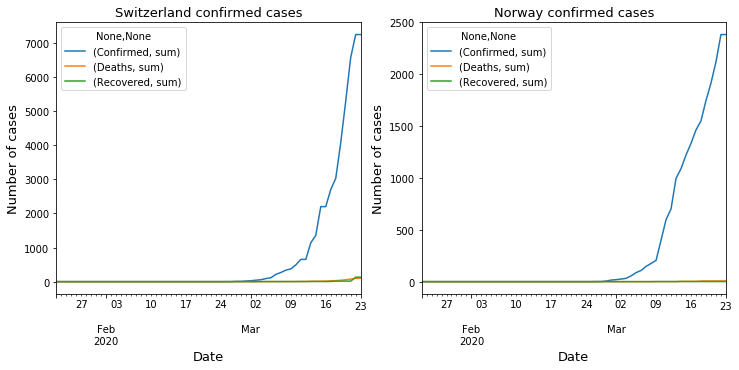

In [45]:
#japan
confirmed_total_date_japan = Japan.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_japan = Japan.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_japan = Japan.groupby(['Date']).agg({'Recovered':['sum']})
total_date_japan = confirmed_total_date_japan.join(deaths_total_date_japan)
total_date_japan = total_date_japan.join(recovered_total_date_japan)

#southKorea
confirmed_total_date_southKorea = SouthKorea.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_southKorea = SouthKorea.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_southKorea = SouthKorea.groupby(['Date']).agg({'Recovered':['sum']})
total_date_southKorea = confirmed_total_date_southKorea.join(deaths_total_date_southKorea)
total_date_southKorea = total_date_southKorea.join(recovered_total_date_southKorea)

#switzerland
confirmed_total_date_switzerland = Switzerland.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_switzerland = Switzerland.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_switzerland = Switzerland.groupby(['Date']).agg({'Recovered':['sum']})
total_date_switzerland = confirmed_total_date_switzerland.join(deaths_total_date_switzerland)
total_date_switzerland = total_date_switzerland.join(recovered_total_date_switzerland)

#norway
confirmed_total_date_norway = Norway.groupby(['Date']).agg({'Confirmed':['sum']})
deaths_total_date_norway = Norway.groupby(['Date']).agg({'Deaths':['sum']})
recovered_total_date_norway = Norway.groupby(['Date']).agg({'Recovered':['sum']})
total_date_norway = confirmed_total_date_norway.join(deaths_total_date_norway)
total_date_norway = total_date_norway.join(recovered_total_date_norway)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
total_date_japan.plot(ax=ax1)
ax1.set_title("Japan confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
total_date_southKorea.plot(ax=ax2)
ax2.set_title("South Korea confirmed cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12,5))
total_date_switzerland.plot(ax=ax3)
ax3.set_title("Switzerland confirmed cases", size=13)
ax3.set_ylabel("Number of cases", size=13)
ax3.set_xlabel("Date", size=13)
total_date_norway.plot(ax=ax4)
ax4.set_title("Norway confirmed cases", size=13)
ax4.set_ylabel("Number of cases", size=13)
ax4.set_xlabel("Date", size=13)

**Observation** 


Since China was the initial infected country, the COVID-19 behavior is different from the rest of the world. The medical system was not prepared for the pandemic, in fact no one was aware of the virus until several cases were reported. Moreover, China government took strong contention measures in a considerable short period of time and, while the virus is widely spread, they have been able to control the increasing of the infections. For the rest of the countries, the general behavior looks cleaner, and in fact the curve resembles a typical epidemiology model like [SIR](http://mat.uab.cat/matmat/PDFv2013/v2013n03.pdf). 
SIR models present a large increasing in the number of infections that, once it reaches the maximum of the contagion, decreases with a lower slope. 

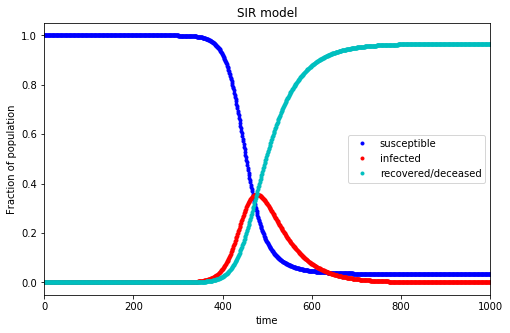

However, South Korea shows a slighty different and interesting curve which needs further analysis. 

### Machine Learning:

The objective in this section consists on  predicting the evolution of the expansion from a data-centric perspective, like any other regression problem. Data was cleaned and enriched beforehand.
Moreover, variables like the total population of a country, the average age of citizens or the density may strongly impact on the COVID-19 transmission behavior. Hence, it's important to consider these factors. I'm using [Tanu's dataset](https://www.kaggle.com/tanuprabhu/population-by-country-2020) based on Web Scrapping for this purpose.

Since we are interested in predicting the future time evolution of the pandemic, i will use simple Linear Regression. However, since the evolution is not linear but exponential (only in the beginning of the infection), a preliminar log transformation is needed. 


The log transformation results in a fancy straight-like line, which is awesome for Linear Regression. However, let me clarify two important points:

* This "roughly exponential behavior" is only true for the initial infection stages of the pandemic (the initial increasing of infections on the SIR model), but that's exactly the point where most countries are at the moment.

* Why do I only extract the last 10 days of data? For three reasons:
    1. In order to capture exactly the very short term component of the evolution.
    2. To prevent the effects of certain variables that have been impacting the transmition speed (quarantine vs free circulation).
    3. To prevent differences on criteria when confirming cases.

In [46]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

The following graphs demonstrates the differences in evolution for the 13 conutries, from March 1st untill Marach 24th: 

In [47]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-03-12', 'ConfirmedCases'] = np.nan
all_data.loc[all_data['Date'] >= '2020-03-12', 'Fatalities'] = np.nan
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province/State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

# Aruba has no Lat nor Long. Inform it manually
all_data.loc[all_data['Lat'].isna()==True, 'Lat'] = 12.510052
all_data.loc[all_data['Long'].isna()==True, 'Long'] = -70.009354


In [48]:
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)
    return df


def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df


ts = time.time()
all_data = calculate_lag(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.57808518409729


In [49]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)

# Load countries data file
world_population = pd.read_csv("population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Med. Age']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Med Age']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'


# Replace Med Age "N.A" by its respective modes, then transform to int
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
all_data = all_data.merge(world_population, left_on='Country/Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Med Age']] = all_data[['Population (2020)', 'Density', 'Med Age']].fillna(0)

# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country/Region'] = le.fit_transform(all_data['Country/Region'])
number_c = all_data['Country/Region']
countries = le.inverse_transform(all_data['Country/Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province/State'] = le.fit_transform(all_data['Province/State'])
number_p = full_table['Province/State']
province = le.inverse_transform(all_data['Province/State'])
province_dict = dict(zip(province, number_p)) 

In [50]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country/Region', 'Province/State', 'ConfirmedCases', 'Fatalities', 
            'Day_num', 'Day', 'Month', 'Year', 'Long', 'Lat', 'Population (2020)', 'Density', 'Med Age']

data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(data):
    
    # Train set
    x_train = data[data.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = data[data.ForecastId == -1]['ConfirmedCases']
    y_train_2 = data[data.ForecastId == -1]['Fatalities']

    # Test set
    x_test = data[data.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

In [51]:
# Select train (real) data from March 1 to March 22nd
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
              '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11','2020-03-12','2020-03-13',
              '2020-03-14', '2020-03-15','2020-03-16','2020-03-17','2020-03-18','2020-03-19','2020-03-20',
              '2020-03-21', '2020-03-22','2020-03-23', '2020-03-24']

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Saudi Arabia')

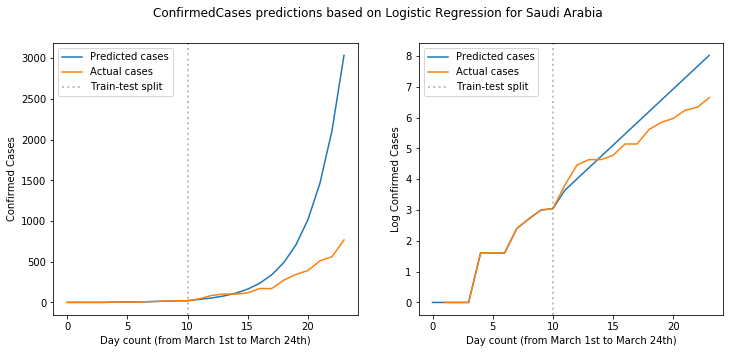

In [52]:
# Filter Spain, run the Linear Regression workflow
country_name = "Saudi Arabia"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Italy')

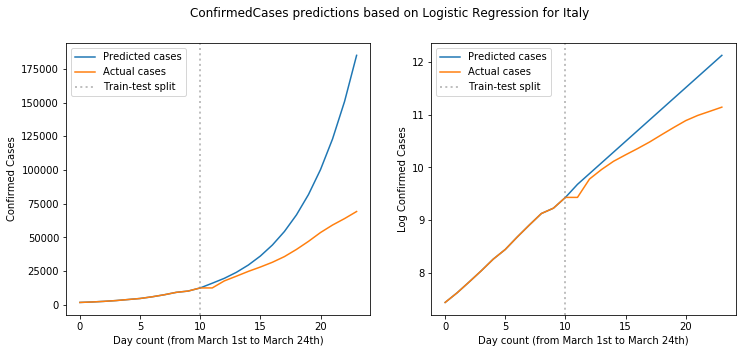

In [53]:
# Filter Spain, run the Linear Regression workflow
country_name = "Italy"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Spain')

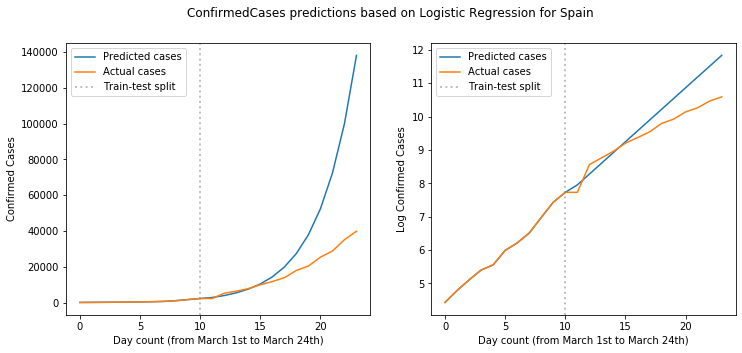

In [54]:
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Germany')

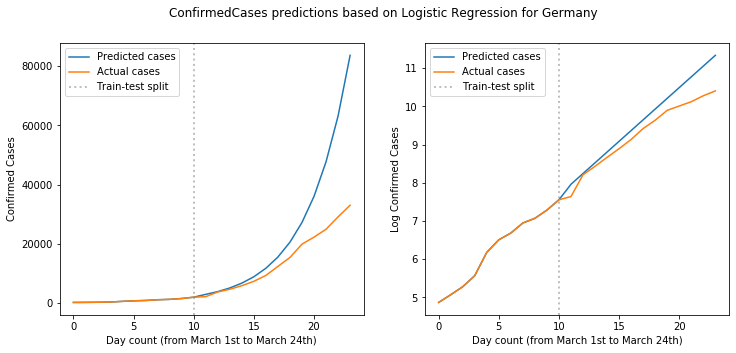

In [55]:
# Filter Spain, run the Linear Regression workflow
country_name = "Germany"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Taiwan*')

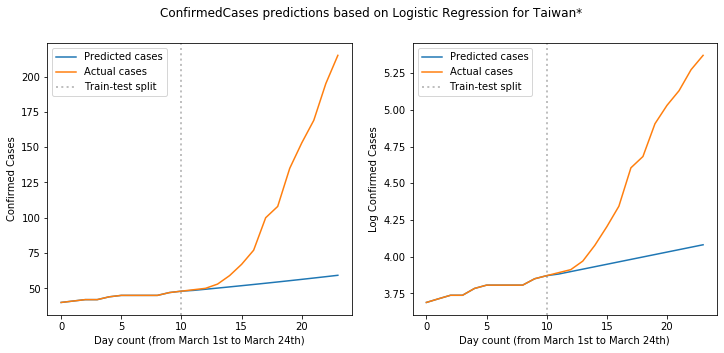

In [56]:
# Filter Spain, run the Linear Regression workflow
country_name = "Taiwan*"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Thailand')

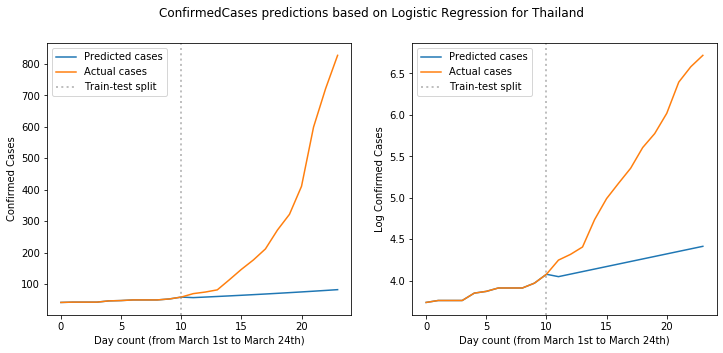

In [57]:
# Filter Spain, run the Linear Regression workflow
country_name = "Thailand"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Japan')

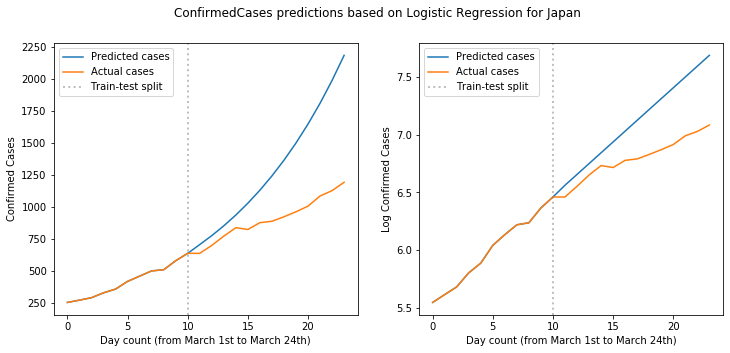

In [58]:
# Filter Spain, run the Linear Regression workflow
country_name = "Japan"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Korea, South')

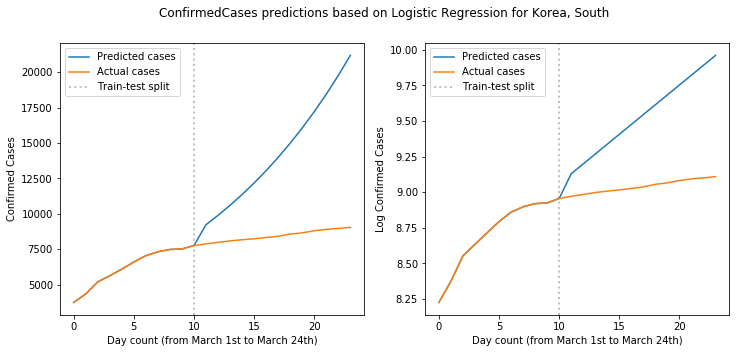

In [59]:
# Filter Spain, run the Linear Regression workflow
country_name = "Korea, South"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Switzerland')

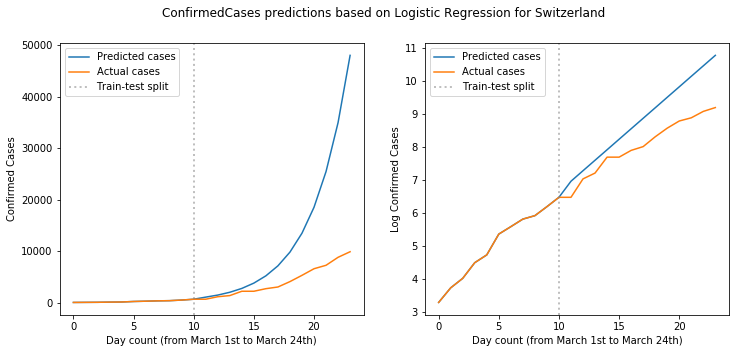

In [60]:
# Filter Spain, run the Linear Regression workflow
country_name = "Switzerland"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Norway')

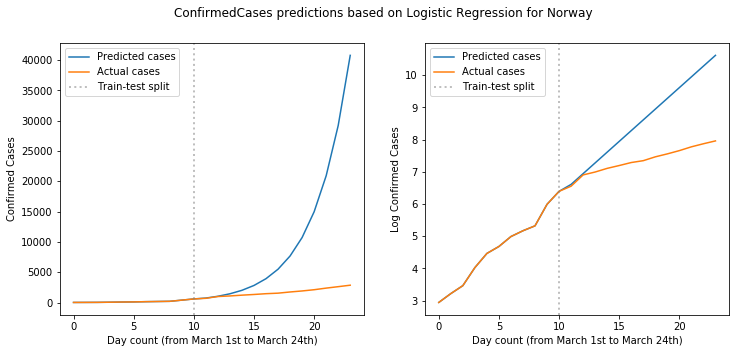

In [61]:
# Filter Spain, run the Linear Regression workflow
country_name = "Norway"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

Text(0.5, 0.98, 'ConfirmedCases predictions based on Logistic Regression for Austria')

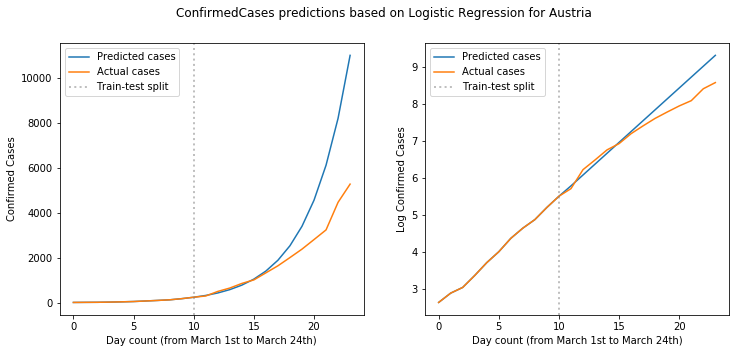

In [62]:
# Filter Spain, run the Linear Regression workflow
country_name = "Austria"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 24th)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 24th)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))

**Observations**:

* The general evolution is captured despite the simplicity of the model
* With training data starting on March 1st, predictions for the first 5 test days tend to be accurate
* Estimations are increasingly worse as time passes (harder to extrapolate)
* Countries that recently confirmed their first contagions are difficult to predict (less data points) 

Most importantly, we can see that the evolution in Saudi Arabia is noticably less, the evolution graph is similar to those for Japan and South Korea. Although Japan and South Korea were with the first countries to report COVID-19 cases, number of cases and increase showed their success in containing the virus for more two months and decreasing number of new cases over time. Saudi Arabia is showing even a faster decrease in the number of new cases, despite that the first case was reported 22 days ago. 

### Recommandation

Saudi Arabia current prevention measures like: quarantine and curfew are showing a rapid impact in the evolution of cases. If Saudi Arabia continues with the current prevention measures, it is expeected that in the following 20 days the number of new cases will reach 0 again.

### Conclusion

To sum up, COVID-19 is a worldwide virus that has been classified as a golbal panademic. Since there is no vaccine untill know the world may take time to recover from the consequences of this virus. However, we can minimize these consequeces with self quarantine social consciousness.  

### References

* https://en.wikipedia.org/wiki/Coronavirus_disease_2019
* https://www.who.int/
* https://github.com/CSSEGISandData/COVID-19
* https://www.kaggle.com/tanuprabhu/population-by-country-2020
* https://www.kaggle.com/c/covid19-global-forecasting-week-1/data
* https://www.kaggle.com/imdevskp/covid-19-analysis-visualization-comparisons
* https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions/notebook
